In [1]:
import pandas as pd
import numpy as np
import math

# This has, at the end Euler Discretization Scheme. Note that if n is too big we cannot compute more psi**n..

### Set Free Parameters

Note this is a particular case. We chose epsilon high, and r_max low, because the coefficients are increasing. And after some point, python cannot compute them anymore as they go to inf. That's why r_max is low and epsilon high

In [2]:
alpha = 0.64
lambd = 0.2
mu = -200
nu = 200

# error measures
epsilon = 0.01
theta = 0.9


r_max = 105

### This function returns the list of coefficients

In [3]:
def returns_all_the_first_r_max_coefficients_as_list_2():
    ''' Run this function. This returns the list of coefficients. Up to a_k where 
        k = r_max. '''
    
    coefficients = [np.nan]*(r_max+1)

    a0 = 0 
    a1 = nu/math.gamma(alpha+1)
    coefficients[0] = a0
    coefficients[1] = a1
    
    
    def recursive_convol_coefficients(list_of_coefficients, k):
        ''' return a*_k^2  given the first k-1 a_m coefficients. 
        k is the coefficient a^_k^2 to be returned'''
        if k==1:
            return 0
        else: 
            sum = 0
            for l in range(1,k):
                a_l = list_of_coefficients[l]
                a_k_l = list_of_coefficients[k-l]
                sum += a_l*a_k_l
            return sum
    
    
    def recursive_coefficients(list_of_coefficients, n):
        ''' Given the convoluted coefficient a_k_star_quadro, 
        Given also n, the coefficient a_n to be returned... Note that n = k+1 !!! 
        returns a_k'''
        k = n-1 # n-1 = k
        a_k_star_quadro = recursive_convol_coefficients(list_of_coefficients, k) 
        a_k = list_of_coefficients[k]  
        a_n = (lambd*a_k_star_quadro + mu*a_k)*math.gamma(alpha*k + 1)/math.gamma(alpha*k + alpha + 1)
    
        return a_n

    for i in range(2, r_max+1):
        coefficients[i] = recursive_coefficients( coefficients, i)
        
    return coefficients

In [4]:
coeff = returns_all_the_first_r_max_coefficients_as_list_2()
#coeff

In [5]:
### Poi posso stampare in un dataframe e metterlo nella tesi i risultati/ coefficienti

# Some Tests For Coefficients: Useless For Thesis

In [6]:
coef_df = pd.DataFrame(coeff)
coef_df = coef_df.rename(columns={0:"val"})
coef_df['abs_val'] = coef_df.val.abs()
coef_df

,val,abs_val
0,0.000000e+00,0.000000e+00
1,2.225580e+02,2.225580e+02
2,-3.469453e+04,3.469453e+04
3,4.307108e+06,4.307108e+06
4,-4.526010e+08,4.526010e+08
...,...,...
101,1.084779e+185,1.084779e+185
102,-7.123154e+186,7.123154e+186
103,4.677547e+188,4.677547e+188
104,-3.071697e+190,3.071697e+190


In [7]:
pd.DataFrame(coef_df.shift(-1).abs_val/coef_df.abs_val).tail(30)

,abs_val
76,65.590355
77,65.594224
78,65.597997
79,65.601677
80,65.605267
81,65.608771
82,65.612191
83,65.615531
84,65.618794
85,65.621981


# Estimating the radius of convergence

### A plot

/home/nicola/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


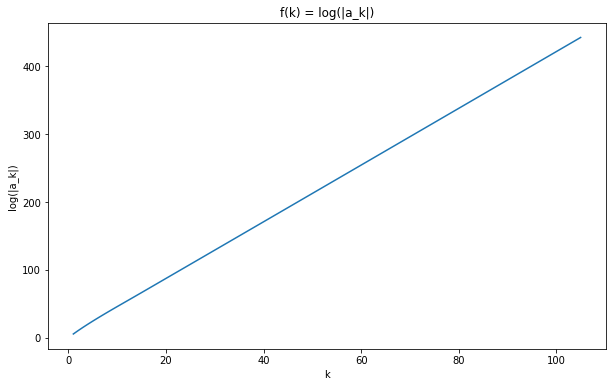

In [8]:
### DO NOT RUN THIS. IT IS A PLOT FOR THE THESIS

ott = pd.DataFrame({ "k": [i for i in range(0,106)], "a_k": coeff}).set_index('k')

ott['c'] = np.log(np.abs(ott['a_k']))

plot = ott['c'].plot( ylabel= "log(|a_k|)", title= "f(k) = log(|a_k|)")

fig = plot.get_figure()
fig.set_size_inches(10, 6)
fig.savefig("output.png", dpi=200)

In [9]:
a_r_max = coeff[-1]
a_primo_r_max = a_r_max*math.gamma(alpha*r_max+1)/(math.gamma(alpha*r_max-alpha+1)*(alpha*r_max+1-alpha))

R_estimate = abs(a_primo_r_max)**(-1/(alpha*r_max))
R_estimate

0.001406484830030425

In [10]:
T = 1/252  ## We will need to use the hybrid, since t= 1/252 è più grande di R_estimate!!
T

0.003968253968253968

### Computing where should we truncate

In [11]:
r_0 = math.log(epsilon*(1-theta))/alpha/math.log(theta)-1
r_0 = int(np.round(r_0)+1)
r_0            ### Hey but this r_0 is independent by n. In fact,
               # We should be fix first n, then compute theta_n(n) (defined below),
               # Only then we can compute r_0, and therefore the truncated coefficients!!!

102

In [12]:
slicing = slice(0,r_0)

coeff_truncated = coeff[slicing]

## Euler Scheme

In [13]:
### We use the theta function defined in 4.6
## IN Truth we set it always fixed to 0.9. Because, anyways, we do not care much for low values of n


In [14]:
# We won't be using this in the first exercise, but maybe in the next exercises we will need it

def theta_n(n):
    ''' Theta in function of n '''
    if n<16:
        return 0.5
    if n<32:
        return 0.65
    if n>4096:
        return 0.925
    else:
        return min(0.65+ 0.3*((n-32)/4064)**0.25  ,0.925)

For convenience we will compute r_0 with a theta fixed (theta = 0.9). Why this?
 Because the value of r_0 changes basing on theta. And, as we observed, if r_0 is too big,
It might be that we don't have enough coefficients. Since in this case the coefficients go to infinity,
 We want to be sure we stay below the threshold. So we use a theta fixed, even for different n's values!

In [15]:
def poly(lst, x):   
    ''' Evaluate the polynomial with coefficients lst= [a0,a1,a2,...] in x
    Pol: a0 + a1*x**alpha + a2*x**(2*alpha) + .... '''
    n, tmp = 0, 0
    for a in lst:
        tmp = tmp + (a * (x**(n*alpha)))
        n += 1

    return tmp

poly([1,2,3], 2)  # 1 + 2*2 + 3*4 

11.401827625012281

In [17]:
def computing_psi_n(n):
    ''' Just Give n. This function makes use of the parameters. Then also of the list "coeff_truncated" 
    '''
    
    disc_times = [k*T/n for k in range(0,n+1)]
    
    theta = 0.9
    #theta = theta_n(n) # Only In This Example, Because The Theta fixed at the beginning would go out otherwise!
    
    
    
    k_0 = math.floor(R_estimate*theta*n/T)  ### Up to t_k_0 we will use truncated series. Then Euler Schema
    
    t_k_0 = disc_times[k_0]
    
    
    values_assumed_in_disc_times = [np.nan]*(n+1)
    
    
    ### Here We Evaluate The Truncated Series!
    for k in range(0,k_0+1):
        values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    
    
    ### Here Instead We Use The Euler Scheme
    def compute_c_i(alpha, l):
        if l == 0:
            return 1
        else: 
            return (l+1)**alpha - l**alpha
    
    
    
    for k in range(k_0+1, n+1):
        factor_1 = 1/math.gamma(alpha + 1)*(T/n)**alpha
        addend_2 = nu*k**alpha 
        addend_3 = 0
        for l in range(1,k):
            psi_n_t_l = values_assumed_in_disc_times[l]
            addend_3 += compute_c_i(alpha, k-l-1)*psi_n_t_l*(lambd*psi_n_t_l + mu)
        
        factor_2 = addend_2 + addend_3
        
        result = factor_1*factor_2
        
        values_assumed_in_disc_times[k] = result
            
    
    print("t_k0=", t_k_0)
    
    #return disc_times, values_assumed_in_disc_times
    return pd.DataFrame({"time": disc_times, "value": values_assumed_in_disc_times}), t_k_0
    

# Plots Do not run the followings. These are for the thesis

t_k0= 0.001240079365079365
t_k0= 0.001240079365079365


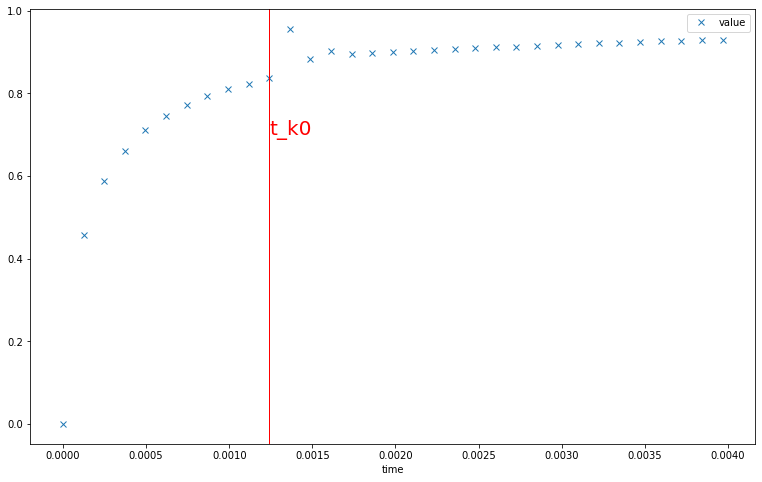

In [18]:
plot = computing_psi_n(32)[0].set_index('time').plot( marker="x", linewidth=0)
tk0 = computing_psi_n(32)[1]

plot.axvline(x = tk0, linewidth=1, color='r')
plot.text(tk0,0.7,"t_k0",rotation=0, fontsize= 20, color="r")


fig = plot.get_figure()
fig.set_size_inches(13, 8)

In [19]:
def plot_psi_n(n, nameToSave):
    df, tk0 = computing_psi_n(n)
    
    plot = df.set_index('time').plot( marker="x", linewidth=0, title = nameToSave[:-4])

    plot.axvline(x = tk0, linewidth=1, color='r')
    plot.text(tk0, 0.8, "t_k0", rotation=0, fontsize= 20, color="r")
    plot.set_ylim=([0,1.2])


    fig = plot.get_figure()
    fig.set_size_inches(13, 8)
    fig.savefig(nameToSave, dpi=100)

t_k0= 0.001263330853174603


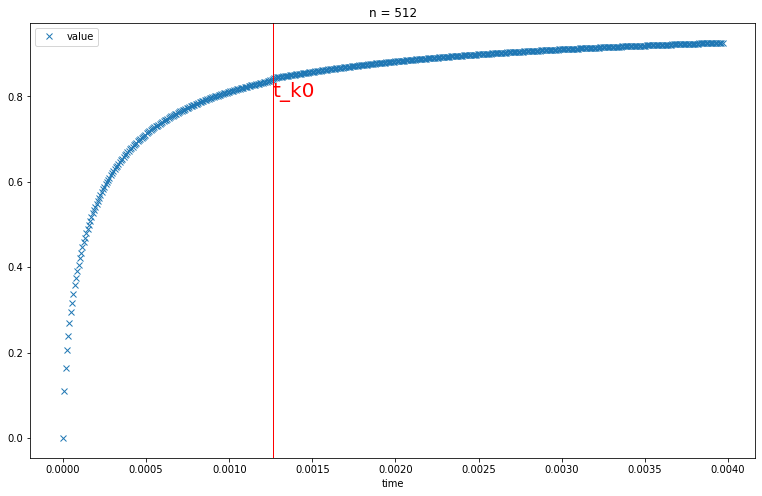

In [20]:
plot_psi_n(512, "n = 512.png")

# Experiment nr. 2 Computing c_1(n)  

In [21]:
def c_1(n):
    return 2*n*(computing_psi_n(n)[0].iloc[-1].value - computing_psi_n(2*n)[0].iloc[-1].value)

In [22]:
c_1(2048)

t_k0= 0.0012652684771825395
t_k0= 0.0012652684771825395


0.1343138004122011

In [23]:
powers_of_two = [2**i for i in range(0,15)]

computing c1 for various n and seeing the time that it takes.

In [24]:
# c_1_ns = [c_1(i) for i in powers_of_two]

# pd.DataFrame(c_1_ns).to_csv('c1ns.csv')



In [25]:
c_1_ns = pd.read_csv("c1ns.csv")
c_1_ns['powers_2'] = [2**i for i in range(0,15)]
c_1_ns = c_1_ns.rename(columns={"0":"c1^n", "powers_2":"n"})[["c1^n", "n"]].set_index('n')
c_1_ns

,c1^n
n,
1,34.276782
2,-64.716952
4,45.992298
8,-18.911034
16,0.262637
32,0.161077
64,0.151405
128,0.143325
256,0.140296


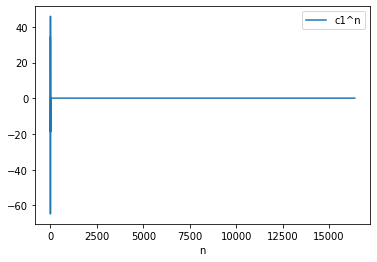

In [26]:
pd.DataFrame(c_1_ns).plot()

# DONT RUN THIS!!

import time
start_time = time.time()

#c_1(4096*2)

print("--- %s seconds ---" % (time.time() - start_time))



df_ci_times = {}
df_ci_values = {}

#for i in [4,8,16,32,64,128,256,512,1024,2048,4096, 4096*2]:
    
#    start_time = time.time()
#    df_ci_values[i] = c_1(i)
#    df_ci_times[i] = time.time() - start_time

final = pd.DataFrame({"n": [key for key in df_ci_times], "c_n": [df_ci_values[key] for key in df_ci_values], "comput_time -sec-": [df_ci_times[key] for key in df_ci_times]})

final = final.set_index("n")
final

final['comput_time_rapport'] = final['comput_time -sec-']/final['comput_time -sec-'].shift(1)

final

#final.to_csv('up_to_4096times8.csv')

final.to_csv('up_to_4096times2.csv')

In [27]:
final = pd.read_csv('up_to_4096times2.csv')
final.set_index('n')

,c_n,comput_time -sec-,comput_time_rapport
n,,,
4,45.992298,0.000978,NaN
8,-18.911034,0.001066,1.089956
16,0.262637,0.001241,1.164169
32,0.161077,0.002010,1.619789
64,0.151405,0.004920,2.447515
128,0.143325,0.016612,3.376496
256,0.140296,0.057853,3.482662
512,0.137850,0.225938,3.905420
1024,0.135780,0.904298,4.002411


In [28]:
final[["n",'c_n']].set_index('n').iloc[1:]

,c_n
n,
8,-18.911034
16,0.262637
32,0.161077
64,0.151405
128,0.143325
256,0.140296
512,0.137850
1024,0.135780
2048,0.134314


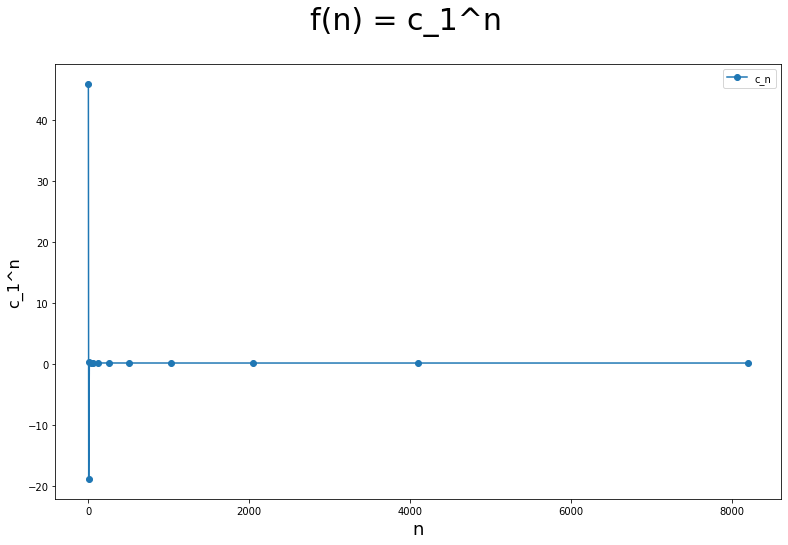

In [29]:
plot = final[["n",'c_n']].set_index('n').plot( marker="o")
fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('f(n) = c_1^n', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('n', fontsize=18)
plot.set_ylabel('c_1^n', fontsize=16)
fig.savefig('c_1^n', dpi=200)


In [30]:
final = final.reset_index()
final['log(n) '] = np.log(final['n'])

cref = 196.510382

final['cn-cref'] = final['c_n'] - cref

final['log(cn-cref) '] = np.log(final['cn-cref'])

final_log = final.iloc[:-1].set_index('log(n) ')

/home/nicola/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


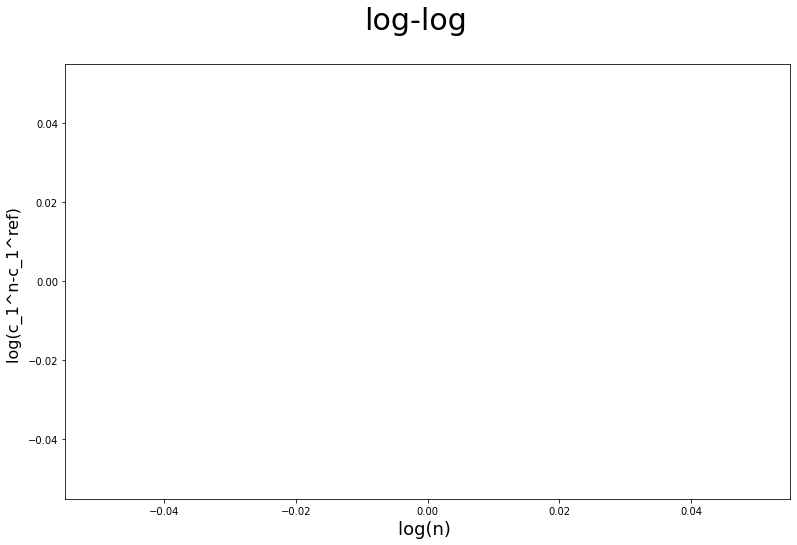

In [31]:
plot = final_log['log(cn-cref) '].plot(marker="o")

fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('log-log', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('log(n) ', fontsize=18)
plot.set_ylabel('log(c_1^n-c_1^ref) ', fontsize=16)
fig.savefig('c_1log', dpi=200)

## Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression

x = final_log.index.values
y = final_log['log(cn-cref) ']

x = x.reshape(-1,1)

reg = LinearRegression().fit(x, y.values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [33]:
reg.coef_

NameError: name 'reg' is not defined

In [34]:
beta = 1 -0.68382593
beta

0.31617407

# Computational Times

In [35]:
comput_times = final.set_index('n')['comput_time -sec-']

In [36]:
comput_times = comput_times.reset_index()

In [37]:
comput_times['logn'] = np.log(comput_times['n'])
comput_times['logcomp'] = np.log(comput_times['comput_time -sec-'])

In [38]:
comput_times = comput_times.set_index('logn')['logcomp']

plot = comput_times.plot(marker= "o")

fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('log-log', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('log(n) ', fontsize=18)
plot.set_ylabel('log(comptime) ', fontsize=16)
fig.savefig('comp_times', dpi=200)

In [39]:
comput_times.values

array([-6.93000803, -6.8438706 , -6.69186299, -6.2095673 , -5.31449403,
       -4.09765547, -2.8498585 , -1.48749324, -0.10059625,  1.30082371,
        2.7073328 ,  4.09858912])

In [40]:


x = comput_times.index.values[6:]
y = comput_times.values[6:]

x = x.reshape(-1,1)

reg = LinearRegression().fit(x, y)

In [41]:
reg.coef_

array([2.00856687])

# Richardson Romberg Extrapolation 

In [42]:
def richardson_romb_2(n) :
    if n%2 == 0:
        return 2*computing_psi_n(n)[0].iloc[-1].value - computing_psi_n(int(n/2))[0].iloc[-1].value
    else:
        print('error. Insert n even')

        
def richardson_romb_3(n):
    if n%4 == 0:
        addend_1 = 1/3*computing_psi_n(int(n/4))[0].iloc[-1].value
        addend_2 = -2*computing_psi_n(int(n/2))[0].iloc[-1].value
        addend_3 = 8/3*computing_psi_n(n)[0].iloc[-1].value
        return addend_1+addend_2+addend_3
    else:
        print('error. Insert n multiple of 4')

In [44]:
richardson_romb_3(8)

t_k0= 0.0
t_k0= 0.000992063492063492
t_k0= 0.000992063492063492


-15.218320047613906

In [45]:
rr2 = {}
compt_time_2 = {}
rr3 = {}
compt_time_3 = {}

# Don't Run the following two take time. Just read the csv. 

In [46]:
import time

for n in [2**k for k in range(5,16)]:
    start_time = time.time()
    rr3[n] = richardson_romb_3(n)
    compt_time_3[n] = time.time()-start_time

t_k0= 0.000992063492063492
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001240079365079365
t_k0= 0.001255580357142857
t_k0= 0.001240079365079365
t_k0= 0.001255580357142857
t_k0= 0.001263330853174603
t_k0= 0.001255580357142857
t_k0= 0.001263330853174603
t_k0= 0.001263330853174603
t_k0= 0.001263330853174603
t_k0= 0.001263330853174603
t_k0= 0.0012652684771825395
t_k0= 0.001263330853174603
t_k0= 0.0012652684771825395
t_k0= 0.0012652684771825395
t_k0= 0.0012652684771825395
t_k0= 0.0012652684771825395


KeyboardInterrupt: 

In [ ]:
for n in [2**k for k in range(5,16)]:
    start_time = time.time()
    rr2[n] = richardson_romb_2(n)
    compt_time_2[n] = time.time()-start_time

In [58]:
fin_extr = pd.DataFrame({"n": [key for key in rr2], "rr2": [rr2[key] for key in rr2], "rr3": [rr3[key] for key in rr3], 
              "comp2" : [compt_time_2[key] for key in rr2], "comp3":  [compt_time_3[key] for key in rr2]})

fin_extr

In [60]:
fin_extr['logn'] = np.log(fin_extr['n'])

In [61]:
fin_extr

,n,rr2,rr3,comp2,comp3,logn
0,32,0.922013,0.522561,0.002253,0.002648,3.465736
1,64,0.925187,0.926245,0.003159,0.003967,4.158883
2,128,0.925338,0.925388,0.005185,0.006413,4.852030
3,256,0.925401,0.925422,0.016054,0.017432,5.545177
4,512,0.925413,0.925417,0.061595,0.062513,6.238325
5,1024,0.925417,0.925419,0.220778,0.232190,6.931472
6,2048,0.925420,0.925420,0.852463,0.906958,7.624619
7,4096,0.925420,0.925420,3.378545,3.681777,8.317766
8,8192,0.925420,0.925420,13.629304,14.739946,9.010913
9,16384,0.925421,0.925421,54.030256,58.376655,9.704061


# Read Here

In [47]:
fin_extr = pd.read_csv('extrapolated.csv')

In [48]:
#fin_extr.to_csv('extrapolated.csv')

In [49]:
fin_extr = fin_extr.set_index('logn')


In [50]:
fin_extr

,Unnamed: 0,n,rr2,rr3,comp2,comp3
logn,,,,,,
3.465736,0,32,0.922013,0.522561,0.002253,0.002648
4.158883,1,64,0.925187,0.926245,0.003159,0.003967
4.852030,2,128,0.925338,0.925388,0.005185,0.006413
5.545177,3,256,0.925401,0.925422,0.016054,0.017432
6.238325,4,512,0.925413,0.925417,0.061595,0.062513
6.931472,5,1024,0.925417,0.925419,0.220778,0.232190
7.624619,6,2048,0.925420,0.925420,0.852463,0.906958
8.317766,7,4096,0.925420,0.925420,3.378545,3.681777
9.010913,8,8192,0.925420,0.925420,13.629304,14.739946


In [51]:
import matplotlib.pyplot as plt

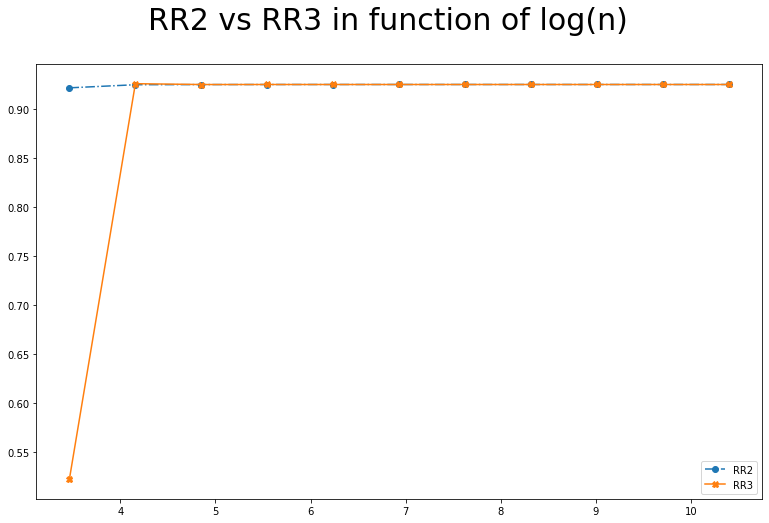

In [52]:
fig, ax = plt.subplots()

ax.plot(fin_extr.index.values, fin_extr['rr2'].values, marker = "o", label="RR2", linestyle="dashdot")

ax.plot(fin_extr.index.values, fin_extr['rr3'].values, marker = "X", label= "RR3")
ax.legend()

fig.suptitle('RR2 vs RR3 in function of log(n)', fontsize=30)    # SET BIG TITLE
fig.set_size_inches(13, 8)
plot.set_xlabel('log(n) ', fontsize=18)
plot.set_ylabel('value ', fontsize=16)
fig.savefig('extrapolatedrr.png', dpi=200)